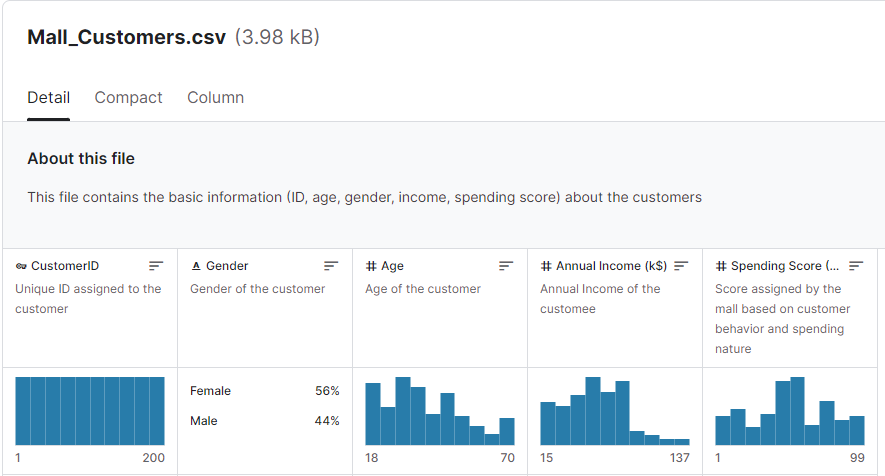

# Library Imports and Setup

In [22]:
# Install the mxnet library required for certain functionalities in SageMaker
!pip install mxnet

#This is a fix for mxnet depenancy issues
import numpy as np
np.bool = np.bool_

# AWS SageMaker and Boto3
import sagemaker
from sagemaker import get_execution_role, KMeans
from sagemaker.image_uris import retrieve
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.tuner import IntegerParameter, CategoricalParameter, HyperparameterTuner
from sagemaker.amazon.common import write_numpy_to_dense_tensor
from sagemaker.inputs import TrainingInput
import boto3
from botocore.exceptions import ClientError

# Data Manipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Additional Libraries
import tarfile
import mxnet as mx
import datetime
import json
import time
from tabulate import tabulate

from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import io

# SageMaker Setup and Configuration

In [17]:
# Initialize a SageMaker Session
# A SageMaker Session helps in managing the interactions with the AWS SageMaker service, such as creating and training models, and deploying endpoints.
sagemaker_session = sagemaker.Session()

# Retrieve the IAM role
# The IAM role is required by SageMaker to access AWS resources (e.g., S3 buckets) on your behalf.
role = get_execution_role()

# Identify the AWS Region of the SageMaker Session
# This information is used to ensure that resources are created in the same region as the SageMaker session.
region = sagemaker_session.boto_region_name

# Create Boto3 Clients for S3 and SageMaker
# These clients enable programmatic access to S3 and SageMaker services for operations like uploading data and creating training jobs.
s3_client = boto3.client('s3')
sagemaker_client = boto3.client('sagemaker')

# Retrieve the Docker image URI for the KMeans algorithm
# This URI is specific to the AWS region and is used to pull the appropriate image for training.
image_uri = retrieve('kmeans', region)

# Define the Default S3 Bucket for SageMaker
# SageMaker requires an S3 bucket to store training data, models, and outputs. Here, we use the session's default bucket.
bucket = sagemaker_session.default_bucket()

# Set the S3 Prefix for Storing Data
# The prefix is used to organize the data in the bucket, making it easier to manage and locate.
prefix = 'sagemaker/kmeans-all'

# Output the IAM Role ARN and AWS Region for verification
print("Execution Role ARN:", role)
print("AWS Region:", region)

[03/27/25 23:55:20] INFO     Same images used for training and inference. Defaulting to image     ]8;id=585834;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=289499;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=697950;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=598575;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Execution Role ARN: arn:aws:iam::625293051840:role/LabRole
AWS Region: us-east-1


# Load and Preprocess the Dataset

In [40]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Load the Dataset
# Load the mall customers dataset from a CSV file into a Pandas DataFrame.
# This allows for easy data manipulation and analysis.
df = pd.read_csv('gym2.csv')

# Encode categorical columns
label_encoders = {}

for col in ["Gender", "Workout_Type"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Convert categories to numbers
    label_encoders[col] = le  # Store the encoder for later use if needed

# Ensure binary columns are integers
binary_cols = ["Gender"]
df[binary_cols] = df[binary_cols].fillna(0)

df[binary_cols] = df[binary_cols].astype(int)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df = df[['Weight (kg)', 'Session_Duration (hours)', 'Workout_Frequency (days/week)', 'Experience_Level']]

# Step 3: Select Relevant Features
# For clustering, we focus on the features
# These features are selected and retained in the DataFrame for further processing.
# df = df[['Diabetes_binary','HighBP','BMI', 'PhysActivity', 'Fruits', 'GenHlth', 'PhysHlth', 'Age', 'Sex']]
# df = df.drop(columns=df.columns[0])
# Step 4: Convert Data for Machine Learning
# Convert the selected DataFrame into a NumPy array of type 'float32'.
# This conversion is necessary as most machine learning frameworks work efficiently with NumPy arrays.
data_np = df.values.astype('float32')

# Step 5: Save and Upload Preprocessed Data
# Save the preprocessed dataset to a CSV file, without the index.
# This file is then uploaded to an S3 bucket, making it accessible for machine learning tasks in SageMaker.
df.to_csv('test_gym.csv', index=False)
data_uri = sagemaker_session.upload_data('test_gym.csv', key_prefix=prefix)

# Output the S3 URI of the uploaded dataset for reference, confirming the successful upload.
print(f"Data uploaded to S3: {data_uri}")

# Finally, display the first few rows of the processed dataset to verify the preprocessing steps.
print(df.head())



Data uploaded to S3: s3://sagemaker-us-east-1-625293051840/sagemaker/kmeans-all/test_gym.csv
   Weight (kg)  Session_Duration (hours)  Workout_Frequency (days/week)  \
0     0.681493                  1.264598                       0.743295   
1     0.049316                  0.127098                       0.743295   
2    -0.271491                 -0.427068                       0.743295   
3    -0.974433                 -1.943735                      -0.352502   
4    -1.309393                 -1.797902                      -0.352502   

   Experience_Level  
0          1.609784  
1          0.257176  
2          0.257176  
3         -1.095432  
4         -1.095432  


# Create a 3D Scatter Plot

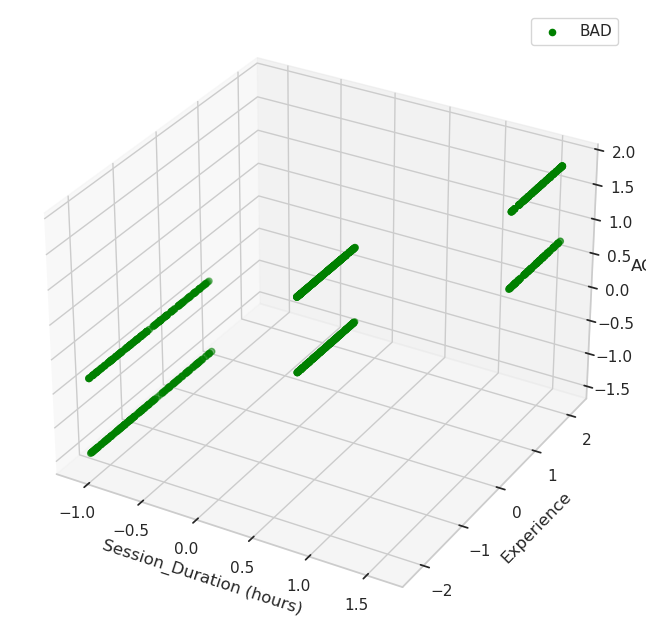

In [42]:
# Import the required libraries for data visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Create a 3D scatter plot
# Initialize a figure with a specific size for the 3D scatter plot.
fig = plt.figure(figsize=(10, 8))

# Add a 3D subplot to the figure
# '111' indicates 1x1 grid, first subplot. 'projection='3d'' is used to create a 3D projection.
ax = fig.add_subplot(111, projection='3d')

# Step 2: Plot data points, colored by gender
# Scatter plot for male customers in blue
# Filters the DataFrame for male customers and plots their age, annual income, and spending score.
# ax.scatter(df[df['Diabetes_binary'] == 0]['BMI'],
#            df[df['Diabetes_binary'] == 0]['Age'],
#            df[df['Diabetes_binary'] == 0]['PhysHlth'],
#            c='green', label='GOOD')

# Scatter plot for female customers in red
# # Filters the DataFrame for female customers and plots their age, annual income, and spending score.
# ax.scatter(df[df['Diabetes_012'] == 1]['BMI'],
#            df[df['Diabetes_012'] == 1]['Age'],
#            df[df['Diabetes_012'] == 1]['PhysHlth'],
#            c='yellow', label='Maybe')

ax.scatter(df['Experience_Level'],
           df['Session_Duration (hours)'],
           df['Workout_Frequency (days/week)'],
           c='green', label='BAD')

# Step 3: Set labels and legend
# Adding axis labels and a legend to make the plot more informative.
ax.set_ylabel('Experience')
ax.set_xlabel('Session_Duration (hours)')
ax.set_zlabel('AGE')
ax.legend()

# Display the plot
plt.show()

# KMeans Model Training

In [43]:
# Define the range of k values for the KMeans clustering
# This range will determine how many models we train, each with a different number of clusters.
k_values = range(2, 8)

# Initialize lists to keep track of the S3 paths for the trained models and their training job names.
model_paths = []
training_jobs = []

# Set the output path in the S3 bucket for the trained models
# This path will be used to store the output (model artifacts) of each training job.
output_path = f's3://{sagemaker_session.default_bucket()}/sagemaker/kmeans-all/output'

# Iterate over each k value to train a separate KMeans model for that number of clusters
for k in k_values:
    # Generate a unique job name for each training job based on the k value
    job_name = f'kmeans-all-k-{k}'
    
    # Initialize the KMeans estimator from SageMaker with the specific k value
    # Configuration includes instance type, number of instances, and the specified k value.
    kmeans = KMeans(
        sagemaker_session=sagemaker_session,
        role=role,
        instance_count=1,
        instance_type='ml.m5.large',
        k=k,
        output_path=output_path,
        job_name=job_name,
        feature_dim=5  # Specify the number of features in the input data
    )
    
    # Start the training job for the KMeans model
    # We use 'wait=False' to start each training job asynchronously.
    kmeans.fit(kmeans.record_set(data_np), wait=False)
    training_jobs.append((k, kmeans.latest_training_job.name))

# After initiating all training jobs, we wait for each to complete and collect their model URIs
for k, job_name in training_jobs:
    # Wait for the completion of the training job
    sagemaker_client.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    
    # Retrieve the S3 URI of the model artifacts for the completed training job
    training_job_description = sagemaker_client.describe_training_job(TrainingJobName=job_name)
    model_s3_uri = training_job_description['ModelArtifacts']['S3ModelArtifacts']
    model_paths.append((k, model_s3_uri))

# Print the S3 paths of the model artifacts for all trained models
# This provides a clear reference to the location of each model for further analysis or deployment.
headers = ['k Value', 'S3 Model Artifact Path']
print(tabulate(model_paths, headers=headers))

[03/28/25 00:34:40] INFO     Same images used for training and inference. Defaulting to image     ]8;id=200209;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=603054;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=459839;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=64675;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=732292;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=227379;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=836020;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=919279;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-28-00-34-40-492        ]8;id=605685;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=904216;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/28/25 00:34:41] INFO     Same images used for training and inference. Defaulting to image     ]8;id=42168;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=735540;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=422354;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=553067;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=769881;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=330324;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=77974;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=724752;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-28-00-34-41-087        ]8;id=723338;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=147121;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/28/25 00:34:42] INFO     Same images used for training and inference. Defaulting to image     ]8;id=987129;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=491916;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=98461;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=908913;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=925841;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=908742;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=374866;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=644555;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-28-00-34-42-326        ]8;id=817942;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=486133;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/28/25 00:34:43] INFO     Same images used for training and inference. Defaulting to image     ]8;id=946833;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=107337;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=463226;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=541861;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=246944;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=598164;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=580993;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=60948;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-28-00-34-43-421        ]8;id=765474;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=228154;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/28/25 00:34:48] INFO     Same images used for training and inference. Defaulting to image     ]8;id=483468;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=784045;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=584380;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=708883;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=770507;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=978648;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=78592;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=231537;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-28-00-34-48-094        ]8;id=696618;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=210827;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/28/25 00:34:49] INFO     Same images used for training and inference. Defaulting to image     ]8;id=691644;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=869415;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=343558;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=741613;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=899981;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=715899;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=102455;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=469656;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-28-00-34-49-309        ]8;id=991698;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=897249;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

  k Value  S3 Model Artifact Path
---------  --------------------------------------------------------------------------------------------------------------------
        2  s3://sagemaker-us-east-1-625293051840/sagemaker/kmeans-all/output/kmeans-2025-03-28-00-34-40-492/output/model.tar.gz
        3  s3://sagemaker-us-east-1-625293051840/sagemaker/kmeans-all/output/kmeans-2025-03-28-00-34-41-087/output/model.tar.gz
        4  s3://sagemaker-us-east-1-625293051840/sagemaker/kmeans-all/output/kmeans-2025-03-28-00-34-42-326/output/model.tar.gz
        5  s3://sagemaker-us-east-1-625293051840/sagemaker/kmeans-all/output/kmeans-2025-03-28-00-34-43-421/output/model.tar.gz
        6  s3://sagemaker-us-east-1-625293051840/sagemaker/kmeans-all/output/kmeans-2025-03-28-00-34-48-094/output/model.tar.gz
        7  s3://sagemaker-us-east-1-625293051840/sagemaker/kmeans-all/output/kmeans-2025-03-28-00-34-49-309/output/model.tar.gz


# Determine K through Elbow Plot

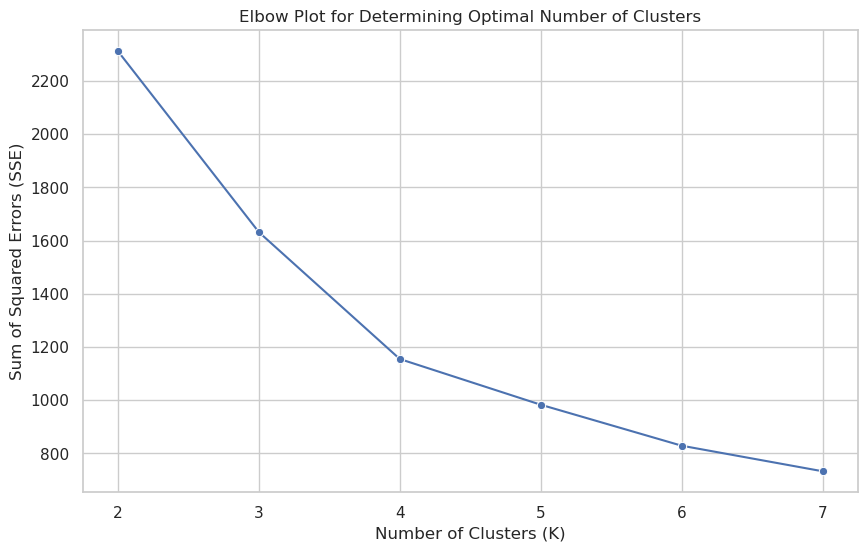

In [44]:
# List to store the Sum of Squared Errors (SSE) for each value of K
sse_values = []

# Iterate over each trained model's path to calculate SSE
for k, model_path in model_paths:
    try:
        # Download the model artifacts from S3
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(sagemaker_session.default_bucket(), model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)
        
        # Extract the model artifacts
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
        
        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()
        
        # Calculate distances from each point to each centroid
        distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
        
        # Determine the closest centroid for each data point
        closest_centroids = np.argmin(distances, axis=0)
        
        # Calculate SSE for this value of K
        sse = np.sum((data_np - centroids[closest_centroids])**2)
        sse_values.append(sse)
    except Exception as e:
        print(f'Error processing model for K={k}: {e}')

# Create and display the Elbow Plot using seaborn and matplotlib
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=[k for k, _ in model_paths], y=sse_values, marker='o')
plt.title('Elbow Plot for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks([k for k, _ in model_paths])
plt.show()

# Determine K through using Silhouette Method

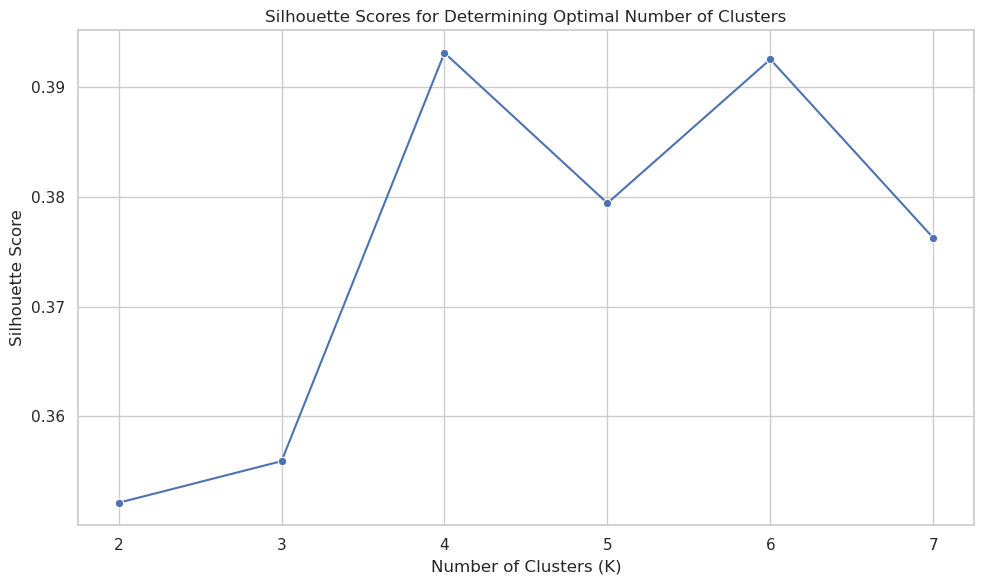

In [45]:
# List to store the silhouette scores for each value of K
silhouette_scores = []

# Iterate over each trained model's path to calculate its silhouette score
for k, model_path in model_paths:
    try:
        # Download the model artifacts from S3
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(sagemaker_session.default_bucket(), model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)
        
        # Extract the model artifacts
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
        
        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()
        
        # Calculate distances from each point to each centroid
        distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
        
        # Determine the closest centroid for each data point
        closest_centroids = np.argmin(distances, axis=0)
        
        # Calculate the silhouette score for this value of K
        silhouette_score_value = silhouette_score(data_np, closest_centroids)
        silhouette_scores.append(silhouette_score_value)
    except Exception as e:
        print(f'Error processing model for K={k}: {e}')

# Plot the silhouette scores for different values of K, if available
if silhouette_scores:  # Ensure the list is not empty
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=[k for k, _ in model_paths], y=silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Determining Optimal Number of Clusters')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()  # Adjust the layout to make sure everything fits without overlap
    plt.show()
else:
    print("No silhouette scores to plot.")


In [23]:
# Specify the best K value
best_k = 3

# Initialize KMeans estimator with specified configuration and hyperparameters
kmeans = sagemaker.estimator.Estimator(
    image_uri=image_uri,  # Docker image URI for KMeans algorithm
    role=role,  # IAM role with permissions for SageMaker operations
    instance_count=1,  # Number of EC2 instances for training
    instance_type='ml.m5.large',  # Type of EC2 instance to use for training
    output_path=f's3://{bucket}/{prefix}/output',  # S3 location for saving trained model artifacts
    sagemaker_session=sagemaker_session,  # SageMaker session object
    hyperparameters={
        'k': best_k,  # Desired number of clusters
        'feature_dim': '2'  # Number of features in input data
    }
)

# Define hyperparameter ranges for tuning
hyperparameter_ranges = {
    'extra_center_factor': IntegerParameter(4, 10),
    'init_method': CategoricalParameter(['random', 'kmeans++']),
    'epochs': IntegerParameter(1, 10),
    'mini_batch_size': IntegerParameter(3000, 15000)
}

# Metric to optimize during hyperparameter tuning
objective_metric_name = 'test:msd'

# Split data into training and testing sets
train_data, test_data = train_test_split(data_np, test_size=0.2, random_state=42)

# Convert and upload training data to S3 in recordIO-wrapped protobuf format
buf = io.BytesIO()
write_numpy_to_dense_tensor(buf, train_data, labels=None)
buf.seek(0)
train_key = f'{prefix}/train/train_data.pbr'
s3_client.upload_fileobj(buf, bucket, train_key)
s3_train_data = f's3://{bucket}/{train_key}'

# Convert and upload testing data to S3 in the same format
buf = io.BytesIO()
write_numpy_to_dense_tensor(buf, test_data, labels=None)
buf.seek(0)
test_key = f'{prefix}/test/test_data.pbr'
s3_client.upload_fileobj(buf, bucket, test_key)
s3_test_data = f's3://{bucket}/{test_key}'

# Define training and testing inputs for SageMaker
train_input = TrainingInput(s3_data=s3_train_data, content_type='application/x-recordio-protobuf')
test_input = TrainingInput(s3_data=s3_test_data, content_type='application/x-recordio-protobuf')

# Configure and initialize hyperparameter tuner
tuner = HyperparameterTuner(
    estimator=kmeans,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type='Minimize',
    max_jobs=10,
    max_parallel_jobs=2
)

# Start hyperparameter tuning job
tuner.fit({'train': train_input, 'test': test_input})
tuner.wait()  # Block until tuning job completes

# Fetch the best model and its hyperparameters
best_estimator = tuner.best_estimator()
print("Best hyperparameters:")
for key, value in best_estimator.hyperparameters().items():
    print(f"{key}: {value}")

# Download the best model artifacts from S3
best_model_s3_uri = best_estimator.model_data
local_path = '/tmp/best_model.tar.gz'
s3_client.download_file(Bucket=bucket, Key=best_model_s3_uri.replace(f's3://{bucket}/', ''), Filename=local_path)

# Extract model parameters
with tarfile.open(local_path) as tar:
    tar.extractall(path='/tmp/best_model')

# Load the KMeans model parameters and compute cluster assignments
kmeans_best_params = mx.ndarray.load('/tmp/best_model/model_algo-1')
centroids_best = kmeans_best_params[0].asnumpy()
distances_best = np.sqrt(((data_np - centroids_best[:, np.newaxis])**2).sum(axis=2))
cluster_labels = np.argmin(distances_best, axis=0)

# Add cluster labels to the original DataFrame
df_mall['Cluster'] = cluster_labels

# Compute model metrics, e.g., Sum of Squared Errors (SSE)
sse_best = np.sum((data_np - centroids_best[cluster_labels])**2)
print(f"Model Metrics for Best Model:\nSSE: {sse_best}")

# Visualize the clustering results
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_mall, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='Set2', s=50)
for i, centroid in enumerate(centroids_best):
    plt.scatter(centroid[0], centroid[1], s=200, c='black', marker='X', label=f'Centroid {i+1}' if i == 0 else None)
plt.title('Mall Customer Segmentation with Clusters and Centroids')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

[03/27/25 23:56:40] WARNING  No finished training job found associated with this estimator.       ]8;id=543469;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=89981;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=581043;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=427209;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     Creating hyperparameter tuning job with name: kmeans-250327-2356       ]8;id=212870;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=859323;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3383\3383]8;;\

......................................................................*


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:63                                                                                   │
│                                                                                                  │
│    60 )                                                                                          │
│    61                                                                                            │
│    62 # Start hyperparameter tuning job                                                          │
│ ❱  63 tuner.fit({'train': train_input, 'test': test_input})                                      │
│    64 tuner.wait()  # Block until tuning job completes                                           │
│    65                                                                                            │
│    66 # Fetch the best model and its hyperparameters                                             │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/workflow/pipeline_c │
│ ontext.py:346 in wrapper                                                                         │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/tuner.py:1039 in    │
│ fit                                                                                              │
│                                                                                                  │
│   1036 │   │   │   self._fit_with_estimator_dict(inputs, job_name, include_cls_metadata, estima  │
│   1037 │   │                                                                                     │
│   1038 │   │   if wait:                                                                          │
│ ❱ 1039 │   │   │   self.latest_tuning_job.wait()                                                 │
│   1040 │                                                                                         │
│   1041 │   def _fit_with_estimator(self, inputs, job_name, include_cls_metadata, **kwargs):      │
│   1042 │   │   """Start tuning for tuner instances that have the ``estimator`` field set."""     │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/tuner.py:2347 in    │
│ wait                                                                                             │
│                                                                                                  │
│   2344 │                                                                                         │
│   2345 │   def wait(self):                                                                       │
│   2346 │   │   """Placeholder docstring."""                                                      │
│ ❱ 2347 │   │   self.sagemaker_session.wait_for_tuning_job(s

# Visualize the centroids for the optimal K value and display the cluster assignments for each datapoint

/tmp/ipykernel_26522/1085832483.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", best_k)  # Use a categorical colormap


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:42                                                                                   │
│                                                                                                  │
│   39 │   # if len(cluster_points) > sample_size:                                                 │
│   40 │   # Use the colormap to assign colors for each cluster                                    │
│   41 │   cluster_color = cluster_colors(i / best_k)  # Get color for this cluster based on in    │
│ ❱ 42 │   ax.scatter(cluster_points[:, 0], cluster_points[:, 4], cluster_points[:, 10],           │
│   43 │   │   │      s=50, color=cluster_color, label=f'Cluster {i+1}')                           │
│   44                                                                                             │
│   45 # Plot centroids                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: index 4 is out of bounds for axis 1 with size 4

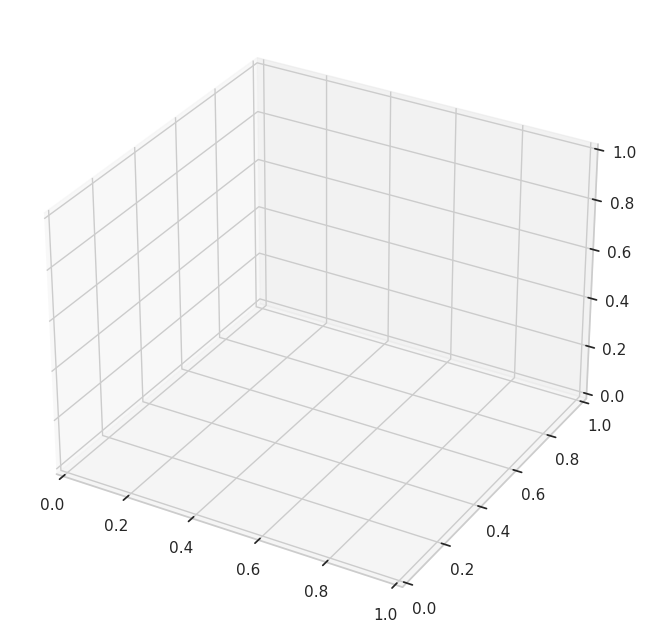

In [51]:
# Specify the optimal number of clusters determined previously
best_k = 4

# Retrieve the model path for the best K value from the list of trained models
best_model_path = next(path for k, path in model_paths if k == best_k)

# Download the best model artifacts from S3
local_path = f'/tmp/model-k-{best_k}.tar.gz'
s3_client.download_file(bucket, best_model_path.replace(f's3://{bucket}/', ''), local_path)

# Extract the model artifacts
with tarfile.open(local_path) as tar:
    tar.extractall(path=f'/tmp/k-{best_k}')

# Load the KMeans model parameters from the extracted files
kmeans_model_params = mx.ndarray.load(f'/tmp/k-{best_k}/model_algo-1')
centroids = kmeans_model_params[0].asnumpy()

# Calculate distances from each point to the centroids and determine closest centroid for each point
distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
closest_centroids = np.argmin(distances, axis=0)

# Initialize a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Set the number of points to sample per cluster
# sample_size = 100  # Adjust as needed

# Define a colormap for consistent cluster colors
cluster_colors = plt.cm.get_cmap("tab10", best_k)  # Use a categorical colormap
# colors = np.where(cluster_points[:, 16] == 1, 'blue', 
#                   np.where(cluster_points[:, 16] == 2, 'red', 'green'))

# Plot data points, color-coded by cluster assignment
for i in range(best_k):
    cluster_points = data_np[closest_centroids == i]
    # If the cluster has more points than the sample size, randomly select a subset
    # if len(cluster_points) > sample_size:        
    # Use the colormap to assign colors for each cluster
    cluster_color = cluster_colors(i / best_k)  # Get color for this cluster based on index
    ax.scatter(cluster_points[:, 0], cluster_points[:, 4], cluster_points[:, 10], 
               s=50, color=cluster_color, label=f'Cluster {i+1}')

# Plot centroids
# ax.scatter(centroids[:, 0], centroids[:, 4], centroids[:, 10], 
#            s=200, c='black', marker='X', label='Centroids')

# print(centroids)

# Customize the view angle for better visualization
ax.view_init(elev=10, azim=5)

# Set titles and labels
ax.set_title(f'Mall Customer Segmentation with K={best_k}')
ax.set_xlabel('AGE')
ax.set_ylabel('BMI')
ax.set_zlabel('GenHealth')
ax.legend()

plt.tight_layout()
plt.show()

In [52]:
# Assuming `df` contains the original dataset and `kmeans.labels_` are the cluster assignments
df['cluster'] = closest_centroids

# Calculate the mean of each feature per cluster
cluster_means = df.groupby('cluster').mean()

# Display the cluster-wise means
print("Cluster Feature Means:\n", cluster_means)

# Optional: Check feature distribution in each cluster
for col in df.columns[:-1]:  # Exclude 'cluster' column from iteration
    print(f"\nFeature: {col}")
    print(df.groupby('cluster')[col].describe())  # Get distribution stats

Cluster Feature Means:
          Weight (kg)  Session_Duration (hours)  Workout_Frequency (days/week)  \
cluster                                                                         
0          -0.449574                 -0.024071                       0.252433   
1          -0.019944                  1.466627                       1.328485   
2           1.706990                 -0.285010                      -0.365394   
3          -0.487675                 -0.759469                      -0.920831   

         Experience_Level  
cluster                    
0                0.257176  
1                1.609784  
2               -0.387302  
3               -1.095432  

Feature: Weight (kg)
         count      mean       std       min       25%       50%       75%  \
cluster                                                                      
0        317.0 -0.449574  0.578874 -1.597175 -0.903667 -0.408305  0.002138   
1        191.0 -0.019944  0.607808 -0.884796 -0.632397  0.327662 

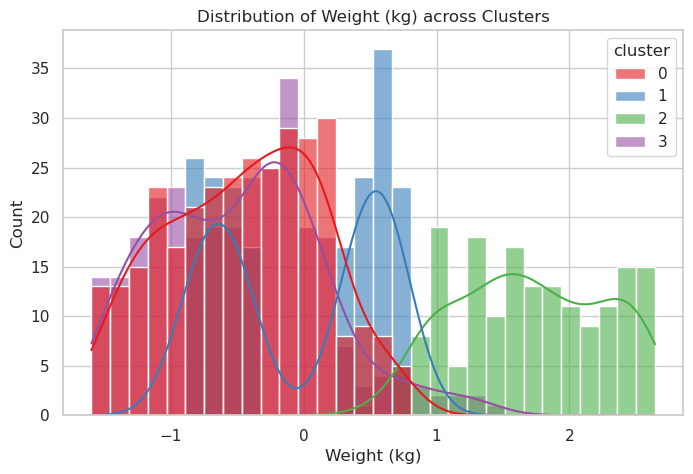

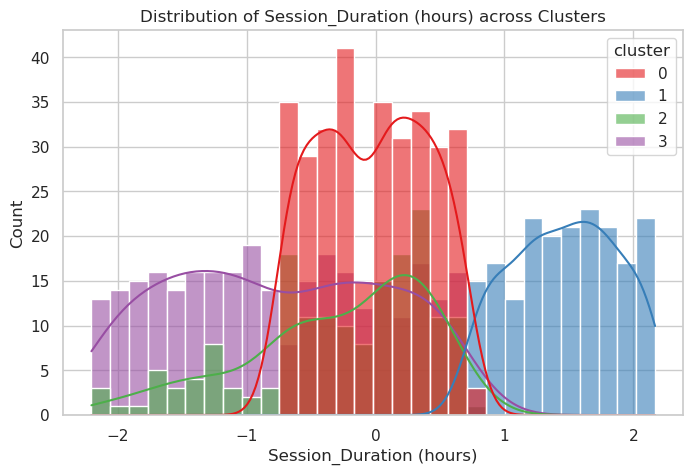

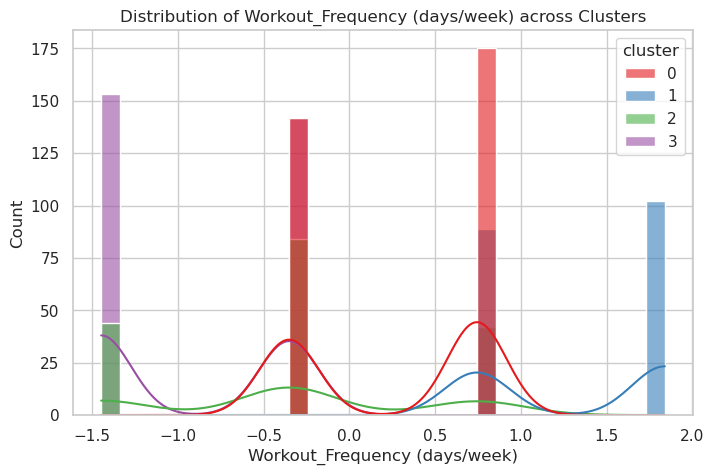

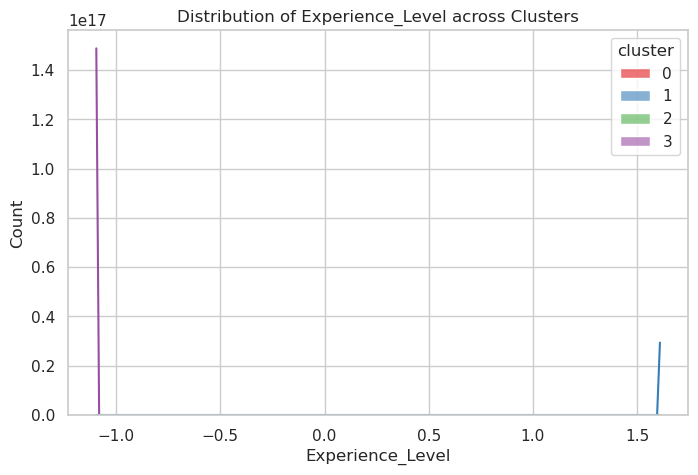

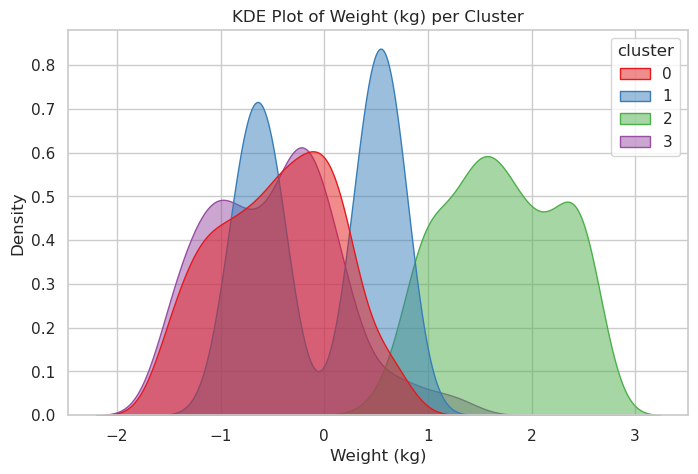

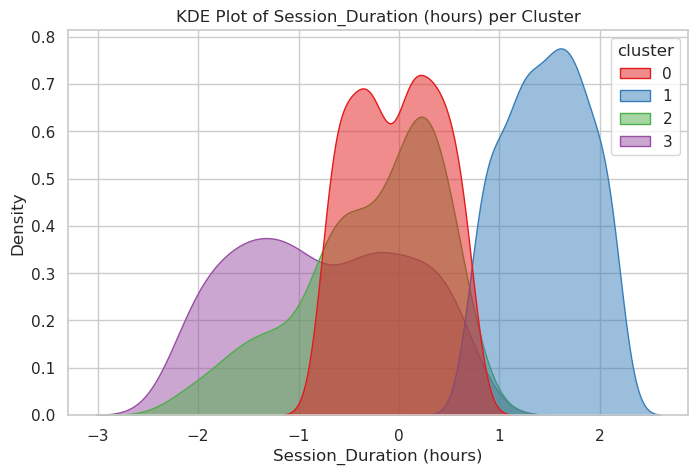

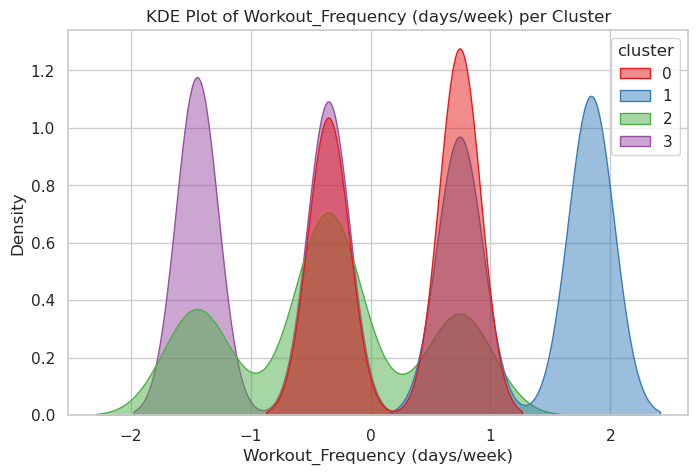

/tmp/ipykernel_26522/3320992704.py:30: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=feature, hue='cluster', fill=True, common_norm=False, palette='Set1', alpha=0.5)


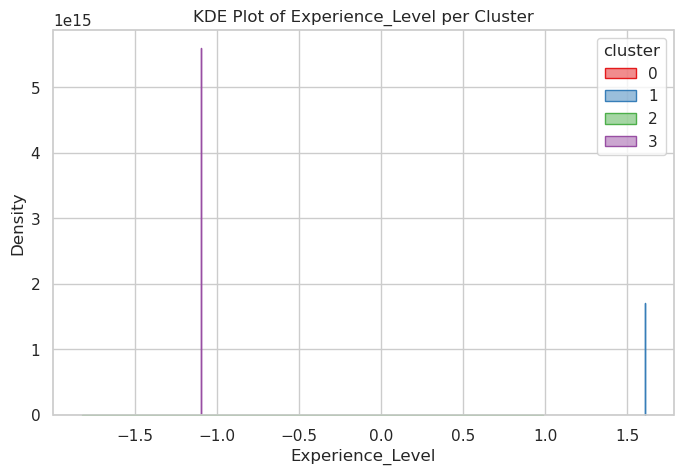

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your dataset and 'cluster' is the assigned cluster column
# Replace 'df' with your actual DataFrame name

features_to_plot = ['Weight (kg)', 'Session_Duration (hours)', 'Workout_Frequency (days/week)', 'Experience_Level']
# Histograms for feature distributions
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=feature, hue='cluster', kde=True, bins=30, palette='Set1', alpha=0.6)
    plt.title(f'Distribution of {feature} across Clusters')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

# Box plots to show the spread of data within each cluster
# for feature in features_to_plot:
#     plt.figure(figsize=(8, 5))
#     sns.boxplot(data=df, x='cluster', y=feature, palette='Set2')
#     plt.title(f'Boxplot of {feature} per Cluster')
#     plt.xlabel('Cluster')
#     plt.ylabel(feature)
#     plt.show()

# KDE plots to visualize the density
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x=feature, hue='cluster', fill=True, common_norm=False, palette='Set1', alpha=0.5)
    plt.title(f'KDE Plot of {feature} per Cluster')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()

# Model Deployment to SageMaker Endpoint

In [11]:
# Specify names for the endpoint and its configuration
endpoint_name = 'kmeans-all'
endpoint_config_name = 'kmeans-all'

# Function to wait for endpoint configuration deletion
def wait_for_endpoint_config_deletion(endpoint_config_name):
    print(f'Waiting for endpoint configuration "{endpoint_config_name}" to be deleted...')
    while True:
        try:
            sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
            time.sleep(5)  # Poll every 5 seconds
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
                break
            else:
                raise

# Check and delete the existing endpoint configuration if it exists
try:
    sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
    wait_for_endpoint_config_deletion(endpoint_config_name)
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')

# Function to wait for endpoint deletion
def wait_for_endpoint_deletion(endpoint_name):
    print(f'Waiting for endpoint "{endpoint_name}" to be deleted...')
    while True:
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            time.sleep(5)  # Poll every 5 seconds
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint "{endpoint_name}" deleted.')
                break
            else:
                raise

# Check and delete the existing endpoint if it exists
try:
    sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    wait_for_endpoint_deletion(endpoint_name)
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint "{endpoint_name}" does not exist.')

# Identify the best model based on prior analysis
best_k = 2  # Assuming best_k is determined through prior analysis
best_model_s3_uri = next(path for k, path in model_paths if k == best_k)

# Create a SageMaker Model object with the best model's artifacts
best_model = Model(
    model_data=best_model_s3_uri,
    image_uri=image_uri,
    role=role,
    sagemaker_session=sagemaker_session
)

# Deploy the model to an endpoint
# Note: This operation can take several minutes to complete.
predictor = best_model.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type='ml.m5.large'
)

print(f'Model deployed to endpoint: {endpoint_name}')

Endpoint configuration "kmeans-all" does not exist.
Endpoint "kmeans-all" does not exist.


[03/27/25 23:45:41] INFO     Creating model with name: kmeans-2025-03-27-23-45-41-649               ]8;id=462538;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=82828;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[03/27/25 23:45:42] INFO     Creating endpoint-config with name kmeans-all                          ]8;id=374589;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=632902;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\

                    INFO     Creating endpoint with name kmeans-all                                 ]8;id=787332;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=525898;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

-------!Model deployed to endpoint: kmeans-all


# Cluster Associations and Centroids

In [12]:
from collections import Counter
from sklearn.metrics import confusion_matrix
# Extract true labels (0 = negative, 1 = positive)
true_labels = data_np[:, 0].astype(int)  # Ensure integer type

# Identify unique clusters
clusters = np.unique(closest_centroids)

# Map clusters to actual labels using majority voting
cluster_to_label = {}

for cluster in clusters:
    indices = np.where(closest_centroids == cluster)[0]
    majority_label = Counter(true_labels[indices]).most_common(1)[0][0]
    cluster_to_label[cluster] = majority_label

# Convert predicted clusters to their assigned labels
predicted_labels = np.array([cluster_to_label[c] for c in closest_centroids])

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[551   0]
 [210   0]]


In [13]:
# Initialize a Predictor object for the deployed SageMaker endpoint
predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer())

def get_user_input(prompt):
    """Function to get user input; allows quitting by typing 'quit'."""
    user_input = input(prompt).strip()
    if user_input.lower() == 'quit':
        return None
    return user_input

def validate_and_prompt(feature_name, feature_prompt):
    """Validate and repeatedly prompt until a valid input or 'quit' is entered."""
    while True:
        user_input = get_user_input(feature_prompt)
        if user_input is None:  # User chose to exit
            return None
        try:
            # For gender, ensure it's 0 or 1; for other features, ensure they're positive numbers
            if feature_name == 'Gender':
                if user_input in ['0', '1']:
                    return user_input
                else:
                    print("Invalid input. Please enter 0 for Female or 1 for Male.")
            else:
                value = float(user_input)
                if value > 0:
                    return str(value)
                else:
                    print(f"Please enter a positive number for {feature_name}.")
        except ValueError:
            print(f"Invalid input. Please enter a number for {feature_name}.")

print("Cluster Prediction Program")
print("Enter the following information for a prediction, or type 'quit' to exit.")

# while True:
    # # Collect inputs from the user
    # gender = validate_and_prompt('Gender', "Enter Gender (0 for Female, 1 for Male): ")
    # if gender is None: break
    # age = validate_and_prompt('Age', "Enter Age: ")
    # if age is None: break
    # annual_income = validate_and_prompt('Annual Income', "Enter Annual Income (k$): ")
    # if annual_income is None: break
    # spending_score = validate_and_prompt('Spending Score', "Enter Spending Score (1-100): ")
    # if spending_score is None: break

# Prepare the data for prediction
# data = f'0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0\n'
# data = f'0.0,0.0,0.0,1.0,30.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,5.0,7.0\n'
# data = f'0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,4.0,6.0,8.0\n'
# data = f'0.0,0.0,0.0,1.0,26.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,5.0,6.0\n'
data = f'2.0,0.0,0.0,1.0,23.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,11.0,6.0,8.0\n' # Cluster 2




# Make prediction
try:
    response = predictor.predict(data)
    # Parse the prediction response
    response_json = json.loads(response)
    cluster = response_json['predictions'][0]['closest_cluster']
    distance = response_json['predictions'][0]['distance_to_cluster']
    # Print the cluster assignment
    print(f"The data point belongs to Cluster {int(cluster)} with a distance of {distance:.2f} to the cluster center.")
except Exception as e:
    print(f"An error occurred during prediction: {str(e)}")

print("Program exited.")

Cluster Prediction Program
Enter the following information for a prediction, or type 'quit' to exit.
An error occurred during prediction: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) from primary with message "unable to evaluate payload provided". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/kmeans-all in account 625293051840 for more information.
Program exited.


# Delete the Endpoint and Endpoint Config

In [14]:
# Prompt for confirmation before proceeding with the deletion
confirmation = input("Are you sure you want to delete the endpoint and endpoint configuration? (yes/no): ")

if confirmation.lower() == 'yes':

    # Function to delete endpoint configuration
    def delete_endpoint_config(endpoint_config_name):
        try:
            sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
            print(f'Endpoint configuration "{endpoint_config_name}" exists. Deleting...')
            sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
            print(f'Endpoint configuration "{endpoint_config_name}" deleted successfully.')
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
            else:
                raise

    # Function to delete the endpoint
    def delete_endpoint(endpoint_name):
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            print(f'Endpoint "{endpoint_name}" exists. Deleting...')
            sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
            print(f'Endpoint "{endpoint_name}" deleted successfully.')
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint "{endpoint_name}" does not exist.')
            else:
                raise

    # Delete the endpoint configuration
    delete_endpoint_config(endpoint_config_name)

    # Delete the endpoint
    delete_endpoint(endpoint_name)

else:
    print("Deletion cancelled. The endpoint and its configuration were not deleted.")

Are you sure you want to delete the endpoint and endpoint configuration? (yes/no):  yes


Endpoint configuration "kmeans-all" exists. Deleting...
Endpoint configuration "kmeans-all" deleted successfully.
Endpoint "kmeans-all" exists. Deleting...
Endpoint "kmeans-all" deleted successfully.
